# Class-discriminative attention maps for Vision Transformer

**Using vision transformer pretrained in a Self-Supervised manner (SSL).**

In [3]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as clr
from glob import glob
from tqdm import tqdm
import numpy as np
import seaborn as sns
import gc
from types import MethodType
import copy
import seaborn as sns
import pandas as pd
import pickle
import os
from functools import partial
from torch import nn

ModuleNotFoundError: No module named 'cmasher'

In [4]:
device = "cuda"

Loading Vision Transformer model pretrained on ImageNet in a Self-Supervised manner and finetuned on the LIDC dataset.

In [2]:
MODEL_TYPE = "Biomarkers"

if MODEL_TYPE == "Biomarkers":
    from Biomarker_SSL import Biomarker_Model
elif MDOEL_TYPE == "End2End":
    from End2End_SSL import End2End_Model

In [4]:
MODEL_NR = 4
PATCH_SIZE = 8
E2E_model = End2End_Model.load_from_checkpoint(f"/home/jbinda/INFORM/LIDC/DINO/checkpoints/best-checkpoint_{MODEL_NR}.ckpt").to(device).eval()
model = E2E_model.model
final_block_norm1 = model.blocks[-1].norm1

Using cache found in /home/jbinda/.cache/torch/hub/facebookresearch_dino_main


In [ ]:
print(model)

### Image loading and utills

#### Computing mean  and std for normalization:

In [6]:
from LIDC_Dataset import LIDC_Dataset

dataset = LIDC_Dataset(data_dir='../dataset',
                       train_mode = True,
                       apply_mask = False,
                       transform = None,
                       labels = 'targets',
                       finetuning = True)

In [7]:
imgs_list = [dataset[i][0] for i in range(len(dataset))]
imgs = torch.stack(imgs_list, axis=0)
channels_mean = torch.mean(imgs)
channels_std = torch.std(imgs)

In [8]:
channels_mean

tensor(-629.1249)

In [9]:
channels_std

tensor(361.6953)

In [10]:
def load_img(crop_path, crop_view="axial", slice_=16):
    """Returns the image as resized and normalized tensor and as original (only resized)"""

    channels_mean = [-629.1249, -629.1249, -629.1249]
    channels_std = [361.6953, 361.6953, 361.6953]

    resizeANDnorm = transforms.Compose(
        [
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=channels_mean, std=channels_std)
        ]
    )
    
    resize = transforms.Compose(
        [
            transforms.Resize((224, 224), antialias=True)
        ]
    )
    
    crop = torch.load(crop_path).float()
    
    if crop_view == "axial":
        img = crop[:, :, slice_]
        mask = crop[:, :, slice_]
        
    elif crop_view == "coronal":
        img = img[:, slice_, :]
        mask = mask[:, slice_, :]
        
    elif crop_view == "sagittal":
        img = img[slice_, :, :]
        mask = mask[slice_, :, :]
    
    img = torch.clamp(img, -1000, 400)
    
    if (len(img.shape) < 3):
        img = img.unsqueeze(0)
    img = img.repeat(3,1,1)
    
    original_img = copy.deepcopy(img)
    # to bring original img in [0, 1] range.
    original_img -= -1000
    original_img = original_img/1400

    img = resizeANDnorm(img).to(device)
    # Moving channels dimmension.
    original_img = torch.movedim(resize(original_img).cpu(), 0, 2)

    # make image divisible by patch size
    w, h = (
        img.shape[1] - img.shape[1] % PATCH_SIZE,
        img.shape[2] - img.shape[2] % PATCH_SIZE,
    )
    img = img[:, :w, :h].unsqueeze(0)
    img.requires_grad = True
    return img, original_img

In [11]:
# Define custom diverging color map
mycmap = clr.LinearSegmentedColormap.from_list(
    "Random gradient 1030",
    (
        (0.000, (0.000, 0.890, 1.000)),
        (0.370, (0.263, 0.443, 0.671)),
        (0.500, (0.000, 0.000, 0.000)),
        (0.630, (0.545, 0.353, 0.267)),
        (1.000, (1.000, 0.651, 0.000)),
    ),
)

In [12]:
def get_cmap(heatmap):
    """Return a diverging colormap, such that 0 is at the center(black)"""
    if heatmap.min() > 0 and heatmap.max() > 0:
        bottom = 0.5
        top = 1.0
    elif heatmap.min() < 0 and heatmap.max() < 0:
        bottom = 0.0
        top = 0.5
    else:
        bottom = 0.5 - abs((heatmap.min() / abs(heatmap).max()) / 2)
        top = 0.5 + abs((heatmap.max() / abs(heatmap).max()) / 2)
    return cmr.get_sub_cmap(mycmap, bottom, top)

In [13]:
def plot_results(original, maps, savename=None, figsize=(9, 9)):
    """Using matplotlib, plot the original image and the relevance maps"""
    plt.figure(figsize=figsize)
    num_plots = 1 + len(maps)

    plt.subplot(1, num_plots, 1)
    plt.imshow(original)
    plt.set_cmap('gray')
    plt.axis("off")
    for i, m in enumerate(maps):
        plt.subplot(1, num_plots, i + 2)
        plt.imshow(m, cmap=get_cmap(m))
        plt.axis("off")
    plt.subplots_adjust(wspace=0.005, hspace=0)
    # save the plot to a file, cropped to only the image
    if savename:
        plt.savefig(f"./maps/SSL_ViT/{savename}.png", bbox_inches="tight", pad_inches=0)
    plt.show()

In [14]:
def print_top_classes(predictions, **kwargs):
    """Print Top-5 predictions"""
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(idx2class[cls_idx])
        if len(idx2class[cls_idx]) > max_str_len:
            max_str_len = len(idx2class[cls_idx])

    print("Top 5 classes:")
    for cls_idx in class_indices:
        output_string = "\t{} : {}".format(cls_idx, idx2class[cls_idx])
        output_string += " " * (max_str_len - len(idx2class[cls_idx])) + "\t\t"
        output_string += "value = {:.3f}\t prob = {:.1f}%".format(
            predictions[0, cls_idx], 100 * prob[0, cls_idx]
        )
        print(output_string)

### Functions to obtain attention maps

In [15]:
def get_attention_map(model, sample_img, head=None, return_raw=False):
    """This returns the attentions when CLS token is used as query in the last attention layer, averaged over all attention heads"""
    attentions = model.get_last_selfattention(sample_img)

    w_featmap = sample_img.shape[-2] // PATCH_SIZE
    h_featmap = sample_img.shape[-1] // PATCH_SIZE

    nh = attentions.shape[1]  # number of heads


    # this extracts the attention when cls is used as query
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    if return_raw:
        return torch.mean(attentions, dim=0).squeeze().detach().cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = torch.nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=PATCH_SIZE, mode="nearest"
    )[0]
    if head == None:
        mean_attention = torch.mean(attentions, dim=0).squeeze().detach().cpu().numpy()
        return mean_attention
    else:
        return attentions[head].squeeze().detach().cpu().numpy()

In [16]:
def get_CDAM(class_score, activation, grad, clip=False, return_raw=False):
    """The class_score can either be the activation of a neuron in the prediction vector or a similarity score between the latent representations of a concept and a sample"""
    class_score.backward()
    # Token 0 is CLS and others are image patch tokens
    tokens = activation["last_att_in"][1:]
    grads = grad["last_att_in"][0][0, 1:]

    attention_scores = torch.tensor(
        [torch.dot(tokens[i], grads[i]) for i in range(len(tokens))]
    )

    if return_raw:
        return attention_scores
    else:
        # clip for higher contrast plots
        if clip:
            attention_scores = torch.clamp(
                attention_scores,
                min=torch.quantile(attention_scores, 0.001),
                max=torch.quantile(attention_scores, 0.999),
            )
        w = int(np.sqrt(attention_scores.squeeze().shape[0]))
        attention_scores = attention_scores.reshape(w, w)

        return torch.nn.functional.interpolate(
            attention_scores.unsqueeze(0).unsqueeze(0),
            scale_factor=PATCH_SIZE,
            mode="nearest",
        ).squeeze()

### Define hooks for token activations and gradients before they enter last attention

In [17]:
# function to extract activation
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()

    return hook


# function to extract gradients
grad = {}

def get_gradient(name):
    def hook(model, input, output):
        grad[name] = output

    return hook

In [18]:
# We are calculating the gradients wrt the normalized inputs to the final attention layer
# In the Dino implementation the normalization happens in the final block,
# whereas in the original Transformer paper https://arxiv.org/pdf/1706.03762.pdf the normalization is done at the end of each transformer block
activation_hook = final_block_norm1.register_forward_hook(
    get_activation("last_att_in")
)
grad_hook = final_block_norm1.register_full_backward_hook(
    get_gradient("last_att_in")
)

In [19]:
def get_maps(model, img, return_raw=False, clip=False):
    """
    Wrapper function to get the attention map and the concept map for a given image and target class.
    In the case of LIDC dataset, target class is a malignant nodule.
    """
    
    pred = model(img)
    class_attention_map = get_CDAM(
        class_score=pred[0][0],
        activation=activation,
        grad=grad,
        return_raw=return_raw,
        clip=clip
    )
    attention_map = get_attention_map(model, img, return_raw=return_raw)
    return attention_map, class_attention_map

### Visualizing class score 

In [20]:
model = E2E_model.model.to(device)

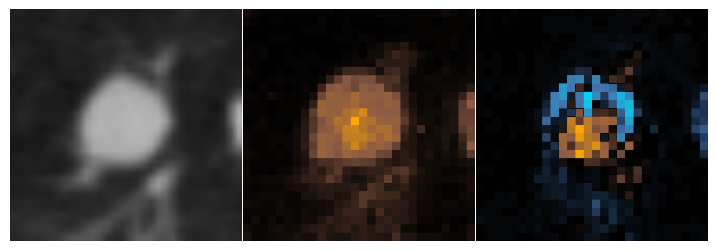

In [21]:
img_path = "/home/jbinda/INFORM/LIDC/dataset/crops/0567.pt"
sample_img, original_img = load_img(img_path)
sample_img.requires_grad = True

attention_map, class_attention_map = get_maps(model, sample_img, clip=True)

plot_results(original_img, [attention_map, class_attention_map], savename="0567")